In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.util.plotting_util import PlottingUtil

import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import math
# from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neural_network import MLPClassifier
# Train a decision tree classifier to predict 'tightest_bounds'
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from simulation_engine.util.plotting_util import PlottingUtil
pd.options.mode.chained_assignment = None  # default='warn'


In [2]:
import re

#setup
results = pd.read_pickle('testrun.pkl')
# results = pd.read_pickle('../simulation_engine/results/binaryIV/06_06/12/results.pkl')
binaryIV = BinaryIV('IV DAG', results)
ATE_algs = binaryIV.get_algorithms('ATE')
PNS_algs = binaryIV.get_algorithms('PNS')
algs = ATE_algs + PNS_algs
results.columns.tolist()


['seed',
 'intercept_X',
 'intercept_Y',
 'b_Z_X',
 'b_U_X',
 'b_X_Y',
 'b_U_Y',
 'ATE_true',
 'PNS_true',
 'p_Y1_mean',
 'p_Y0_mean',
 'p_U',
 'p_Z',
 'Z',
 'U',
 'X',
 'Y',
 'entropy_Z',
 'entropy_U',
 'entropy_X',
 'entropy_Y',
 'sigma_X',
 'sigma_Y',
 'squasher_X_name',
 'squasher_Y_name',
 'ATE_2SLS-0.99_bound_lower',
 'ATE_2SLS-0.99_bound_upper',
 'ATE_2SLS-0.99_bound_valid',
 'ATE_2SLS-0.99_bound_width',
 'ATE_2SLS-0.99_bound_failed',
 'ATE_2SLS-0.98_bound_lower',
 'ATE_2SLS-0.98_bound_upper',
 'ATE_2SLS-0.98_bound_valid',
 'ATE_2SLS-0.98_bound_width',
 'ATE_2SLS-0.98_bound_failed',
 'ATE_2SLS-0.95_bound_lower',
 'ATE_2SLS-0.95_bound_upper',
 'ATE_2SLS-0.95_bound_valid',
 'ATE_2SLS-0.95_bound_width',
 'ATE_2SLS-0.95_bound_failed',
 'ATE_causaloptim_bound_lower',
 'ATE_causaloptim_bound_upper',
 'ATE_causaloptim_bound_valid',
 'ATE_causaloptim_bound_width',
 'ATE_causaloptim_bound_failed',
 'PNS_causaloptim_bound_lower',
 'PNS_causaloptim_bound_upper',
 'PNS_causaloptim_bound_val

In [39]:
results['entropy_U'].describe()

count    2000.000000
mean        0.683512
std         0.295577
min        -0.000000
25%         0.475304
50%         0.770973
75%         0.953694
max         1.000000
Name: entropy_U, dtype: float64

In [ ]:
ate_cols = [col for col in results.columns if col.startswith('ATE_')]
algorithm_names = set()
for col in ate_cols:
    match = re.match(r'ATE_([^_]+)', col)
    if match and match.group(1) != 'true':
        algorithm_names.add('ATE_'+match.group(1))
algorithm_names = sorted(algorithm_names)

                    Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width Invalid Δ (%)
       ATE_entropybounds-0.10          0.00            20.00          0.5104      0.8083          2.35
           ATE_zaffalonbounds          0.00             0.00          0.6188      0.6188           N/A
       ATE_entropybounds-0.20          0.00             0.00          0.7383      0.7383           N/A
                ATE_tianpearl          0.00            20.00          0.7889      1.0311          5.63
              ATE_causaloptim         20.00            25.00          0.8194      1.2916          8.99
                ATE_autobound         20.00            25.00          0.8380      1.3028          6.67
  ATE_entropybounds-trueTheta          0.00             0.00          0.9408      0.9408           N/A
ATE_entropybounds-randomTheta          0.00             0.00          0.9798      0.9798           N/A
       ATE_entropybounds-0.80          0.00             0.00          0.9

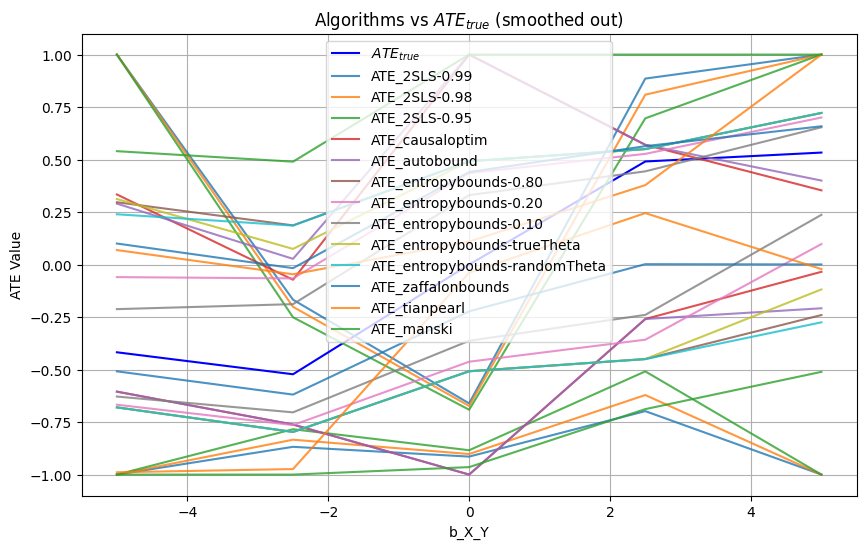

In [4]:
#ATE Evaluation
# Extract unique algorithm names from columns like 'ATE_{algorithm_name}_{...}'
algorithm_names = PlottingUtil.extract_algorithm_names(results, 'ATE')
PlottingUtil.print_bound_statistics_table(results, algorithm_names)
PlottingUtil.plot_smoothed_query_vs_bounds(results, 'ATE', algorithm_names, 1)

             Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width Bound Width Invalid Δ (%)
           PNS_nonpara          0.00            27.55          0.1915      0.4142          2.69
    PNS_zaffalonbounds          0.00             1.50          0.3918      0.4009          2.61
       PNS_causaloptim          4.50            11.47          0.4106      0.5017          6.57
         PNS_autobound          1.20             1.47          0.4279      0.4431          1.54
PNS_entropybounds-0.10          0.00             0.25          0.5024      0.5036          1.34
PNS_entropybounds-0.20          0.00             0.10          0.5771      0.5775          1.06
PNS_entropybounds-0.80          0.00             0.10          0.7126      0.7129          1.06


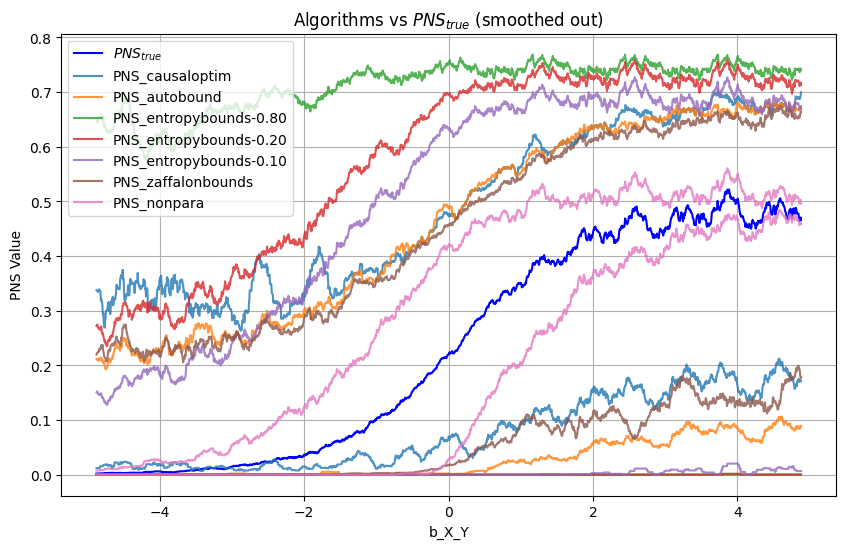

In [21]:
#PNS Evaluation
algorithm_names = PlottingUtil.extract_algorithm_names(results, 'PNS')
PlottingUtil.print_bound_statistics_table(results, algorithm_names, 'PNS')
PlottingUtil.plot_smoothed_query_vs_bounds(results, 'PNS', algorithm_names, 50)

ATE algorithms: ['2SLS-0.99', '2SLS-0.98', 'causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']
PNS algorithms: ['causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']
PNS algorithms: ['causaloptim', 'autobound', 'entropybounds-0.80', 'entropybounds-0.20', 'entropybounds-0.10', 'zaffalonbounds', 'nonpara']


d:\TUM Workspace\Thesis Workspace\causal-bounds\binaryIV\..\simulation_engine\util\plotting_util.py:233: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index, rotation=45, ha='right')


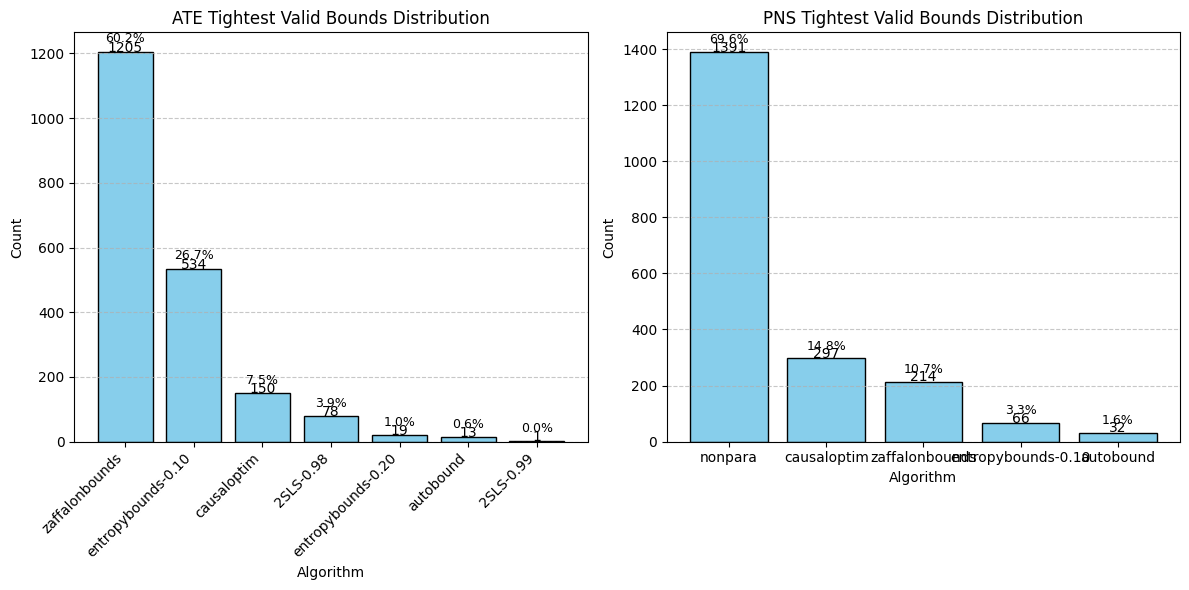

In [38]:
df = results.copy()
# Find tightest bounds without requiring bounds to be valid
tb = PlottingUtil.compute_tightest_bound_valid(df)
PlottingUtil.plot_tightest_bounds_distribution(tb, 'true')
